In [ ]:
!pip install flask-ngrok`

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template_string
from werkzeug.utils import secure_filename
from PIL import Image

In [ ]:
from google.colab import files
uploaded = files.upload()  # Pilih file 'data.zip'

Saving data.zip to data.zip


In [ ]:
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [ ]:
os.listdir("dataset")

['garbage_classification']

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

splitfolders.ratio("dataset/garbage_classification", output="dataset/split_data", seed=42, ratio=(.8, .2), move=False)

Copying files: 15515 files [00:02, 6001.89 files/s]


In [ ]:
train_dir = 'dataset/split_data/train'
val_dir = 'dataset/split_data/val'

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 12409 images belonging to 12 classes.
Found 3106 images belonging to 12 classes.


In [ ]:
train_dir = 'dataset/split_data/train'
val_dir = 'dataset/split_data/val'

img_height, img_width = 150, 150
batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 12409 images belonging to 12 classes.
Found 3106 images belonging to 12 classes.


In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')  # output 12 kelas
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,900 (18.42 MB)

 Trainable params: 4,829,900 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10  # Bisa ditambah sesuai kebutuhan

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.4352 - loss: 1.7744 - val_accuracy: 0.6269 - val_loss: 1.1230
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step - accuracy: 0.6262 - loss: 1.1433 - val_accuracy: 0.6780 - val_loss: 0.9704
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.6951 - loss: 0.9473 - val_accuracy: 0.7193 - val_loss: 0.8521
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.7252 - loss: 0.8408 - val_accuracy: 0.7341 - val_loss: 0.8368
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7635 - loss: 0.7109 - val_accuracy: 0.7566 - val_loss: 0.7564
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.7881 - loss: 0.6390 - val_accuracy: 0.7576 - val_loss: 0.7584
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.8165 - loss: 0.5473 - val_accuracy: 0.7531 - val_loss: 0.8452
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.8429 - loss: 0.4626 - val_accurac

In [ ]:
# Ganti jumlah epoch jadi lebih banyak
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.8927 - loss: 0.3052 - val_accuracy: 0.7598 - val_loss: 0.8496
Epoch 2/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9013 - loss: 0.2844 - val_accuracy: 0.7791 - val_loss: 0.9146
Epoch 3/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9125 - loss: 0.2458 - val_accuracy: 0.7621 - val_loss: 1.0412
Epoch 4/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9186 - loss: 0.2284 - val_accuracy: 0.7788 - val_loss: 1.0073
Epoch 5/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9344 - loss: 0.1896 - val_accuracy: 0.7737 - val_loss: 1.0129
Epoch 6/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.9322 - loss: 0.1906 - val_accuracy: 0.7634 - val_loss: 1.1744
Epoch 7/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.9320 - loss: 0.1929 - val_accuracy: 0.7782 - val_loss: 1.1393
Epoch 8/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.9447 - loss: 0.1564 - 

In [ ]:
model.save("garbage_model.h5")

In [ ]:
model.save('garbage_model.keras')  # format baru

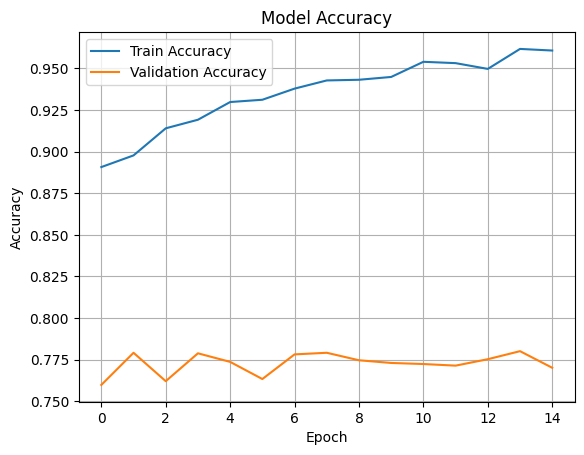

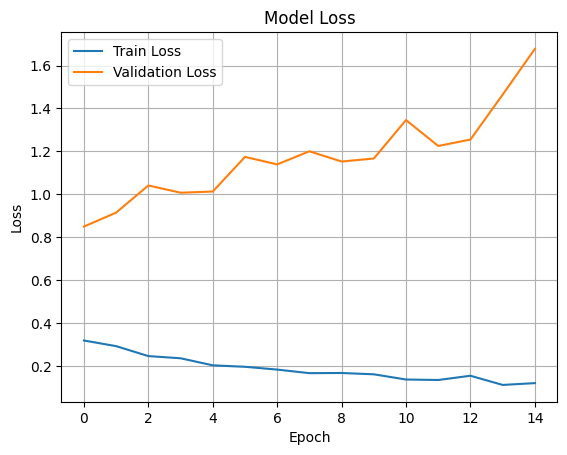

In [ ]:
import matplotlib.pyplot as plt

# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()  # pilih 1 gambar sampah

Saving sepatu bekas.jpg to sepatu bekas.jpg


In [ ]:
import os

# Ganti nama file agar lebih aman
os.rename("sepatu bekas.jpg", "sepatu_bekas.jpg")
file_name = "sepatu_bekas.jpg"

In [ ]:
file_name = "sepatu_bekas.jpg"

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('garbage_model.keras')  # atau 'garbage_model.h5'

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
class_names = list(train_generator.class_indices.keys())

In [ ]:
import json

# Simpan label
with open("class_names.json", "w") as f:
    json.dump(train_generator.class_indices, f)

In [ ]:
with open("class_names.json", "r") as f:
    class_indices = json.load(f)

# Convert indeks ke nama kelas
class_names = [k for k, v in sorted(class_indices.items(), key=lambda x: x[1])]

In [ ]:
from PIL import Image
import numpy as np

# Baca dan preprocessing gambar
img = Image.open(file_name).resize((150, 150)).convert('RGB')
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

print(f"Prediksi: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
Prediksi: shoes


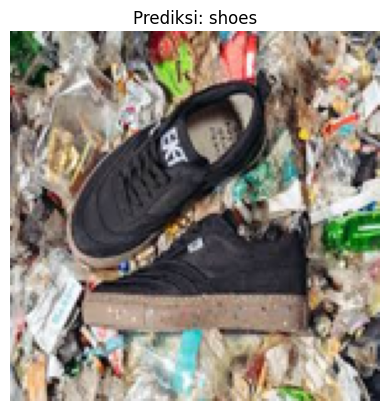

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f"Prediksi: {predicted_class}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


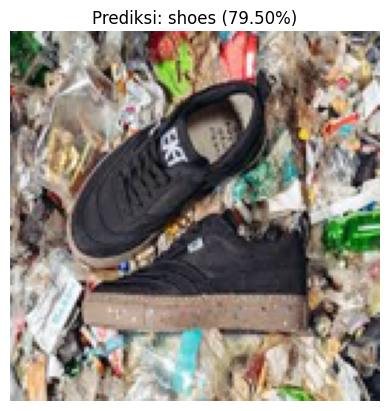

Hasil Deteksi: shoes (79.50%)


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1. Load model
model = load_model("garbage_model.keras")  # atau .h5

# 2. Kelas target
class_names = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes',
               'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

# 3. Load dan proses gambar
file_name = "sepatu_bekas.jpg"  # atau nama file kamu
img = Image.open(file_name).resize((150, 150)).convert('RGB')
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 4. Prediksi
predictions = model.predict(img_array)[0]  # hasil shape (12,)
predicted_index = np.argmax(predictions)
predicted_class = class_names[predicted_index]
confidence = predictions[predicted_index] * 100

# 5. Tampilkan hasil
plt.imshow(img)
plt.title(f"Prediksi: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()

print(f"Hasil Deteksi: {predicted_class} ({confidence:.2f}%)")

In [ ]:
import os
os.makedirs("uploaded_images", exist_ok=True)

In [ ]:
!pip install flask-ngrok

In [ ]:
model.save("garbage_model.keras")

In [ ]:
from google.colab import files
files.download("garbage_model.keras")
files.download("class_names.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

# Lihat isi folder saat ini
os.listdir()

['.config', 'sample_data']

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving garbage_model.keras to garbage_model.keras


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("garbage_model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("garbage_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpc0plsc2o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  138545830137104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830137872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830141328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830140368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830143248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830144016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830143056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830142672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830144208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138545830146128: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
from google.colab import files
files.download('garbage_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
labels = [
    "battery",
    "biological",
    "brown-glass",
    "cardboard",
    "clothes",
    "green-glass",
    "metal",
    "paper",
    "plastic",
    "shoes",
    "trash",
    "white-glass"
]

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

In [ ]:
from google.colab import files
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>